In [ ]:
pip install -U libsvm-official

In [2]:
import scipy
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from libsvm.svmutil import *

## Data Preparation

In [4]:
# Reading data
df = pd.read_csv('abalone.data',header=None,sep=',')

# Code the gender by number
df[0]=df[0].replace(['M','F','I'],[0,1,2])

# Extract the label
df.rename(columns={8:'label'},inplace=True)

# Change the label to {0,1} as a binary classification.
df["label"] = np.where(df["label"]<=9, 0, 1)

# Change the dataframe to the required format
index=[]
for i in range(8):
  df.insert(i, f'index {i+1}', f'{i+1}:', True)
  df[f'index {i+1}']=df[f'index {i+1}']+df[i].astype(str)
  index.append(f'index {i+1}')
x=df[index]
data = pd.merge(df["label"],x,left_index=True,right_index=True)

# Save the data 
os.makedirs('/', exist_ok=True)  
data.to_csv('data',header=False,index=False,sep=' ')

In [5]:
# Read the problem
y, x = svm_read_problem('data', return_scipy=True)

# Split the training and testing set
y_train, x_train = y[:3133], x[:3133]
y_test, x_test = y[3133:],  x[3133:]

# Apply scaling based on training data
scale_param = csr_find_scale_param(x_train, lower=0)
scaled_train_x = csr_scale(x_train, scale_param)
scaled_test_x = csr_scale(x_test, scale_param)

In [6]:
# Shuffle the training set
index = np.arange(np.shape(scaled_train_x)[0])
np.random.shuffle(index)
shuffled_scaled_train_x = scaled_train_x[index, :]
shuffled_train_y = y_train[index]


## Cross Validation

In [29]:
# Split the shuffled set into 5:
index = np.arange(np.shape(scaled_train_x)[0])
split_index = np.array_split(index,5)

def cross_val(d,C,K):
  # Loop k times
  m = []
  err = []
  nr_sv = 0
  for k in range(K):
    # Partition the set
    index = np.arange(np.shape(scaled_train_x)[0])
    np.delete(index,split_index[k])
    # Cross validation training set
    cv_train_y = shuffled_train_y[index]
    cv_train_x = shuffled_scaled_train_x[index,:]
    # Cross validation testing set
    cv_test_y = shuffled_train_y[split_index[k]]
    cv_test_x = shuffled_scaled_train_x[split_index[k],:]
    # Training 
    m.append(svm_train(cv_train_y,cv_train_x,f'-t 1 -d {d} -c {3**C}'))
    # Predicting
    p,_,_=svm_predict(cv_test_y,cv_test_x,m[k],'-q')
    # Calculate the error
    err.append(np.sum(p!=cv_test_y)/len(split_index[k]))
  # Calculate the mean and std of error
  mean = np.mean(err)
  std = np.std(err)
  return mean,std,m

## Grid Search for Optimal Parameters

In [10]:
# Search for optimal d and C
mean = []
std = []
for i,d in enumerate(range(1,6)):
  mean.append([])
  std.append([])
  for j,C in enumerate(range(-10,11,2)):
    # Get the mean and std for cross validation error
    mean_,std_,_ = cross_val(d,C,5)
    mean[i].append(mean_)
    std[i].append(std_)

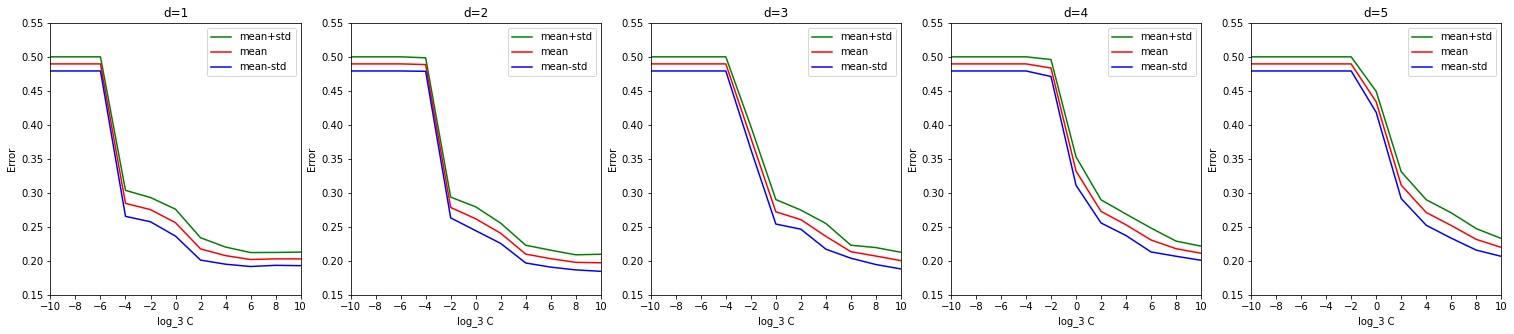

In [18]:
# Plot the error of cross validation
fig, ax = plt.subplots(1,5,figsize=(26,5))  
for i in range(5):
  ax[i].plot(range(-10,11,2), np.add(mean[i],std[i]),'g',label='mean+std'); 
  ax[i].plot(range(-10,11,2), mean[i],'r',label='mean'); 
  ax[i].plot(range(-10,11,2), np.subtract(mean[i],std[i]),'b',label='mean-std');
  ax[i].set_xlabel('log_3 C') 
  ax[i].set_ylabel('Error')
  ax[i].set_title(f"d={i+1}")
  ax[i].set_ylim([0.15, 0.55])
  ax[i].set_xlim([-10, 10])
  ax[i].xaxis.set_ticks(np.arange(-10, 11, 2.0))
  ax[i].legend();

In [45]:
# Find the optimal parameter
F = 5 # Fold
D = 5 # Degree
C = 8 # Parameter
mean = []
nr_sv = []
err = []
for j,d in enumerate(range(1,D+1)):
  # Calculate the cross validation error
  mean_,_,m = cross_val(d,C,F)
  mean.append(mean_)
  # Get the average number of support vectors
  nr_sv_ = 0
  for k in range(F):
    nr_sv_ += m[k].get_nr_sv()
  nr_sv.append(nr_sv_/F)
  # Get the test error 
  model = svm_train(y_train,x_train,f'-t 1 -d {d} -c {3**C}')
  p,acc_,_ = svm_predict(y_test,x_test,model,'-q')
  err.append(np.sum(p!=y_test)/len(y_test))

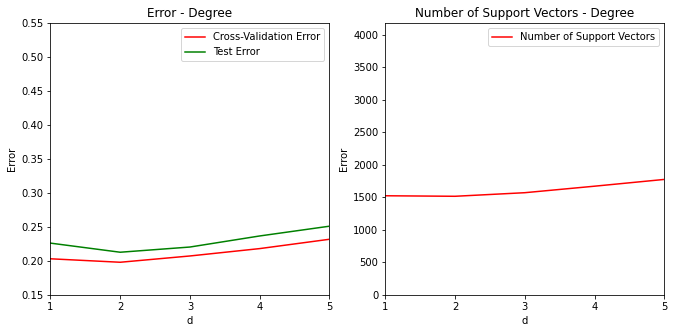

In [46]:
# Plot the error of cross validation as a function of d
fig, ax = plt.subplots(1,2,figsize=(11,5))
# First plot
ax[0].set_title("Error - Degree")
ax[0].plot(range(1,6), mean,'r',label='Cross-Validation Error')
ax[0].plot(range(1,6), err,'g',label='Test Error')
ax[0].set_xlabel('d') 
ax[0].set_ylabel('Error')
ax[0].set_ylim([0.15, 0.55])
ax[0].set_xlim([1, 5])
ax[0].xaxis.set_ticks(np.arange(1, 6, 1.0))
ax[0].legend();
# Second plot
ax[1].set_title("Number of Support Vectors - Degree")
ax[1].plot(range(1,6), nr_sv,'r',label='Number of Support Vectors')
ax[1].set_xlabel('d') 
ax[1].set_ylabel('Error')
ax[1].set_ylim([0, 4177])
ax[1].set_xlim([1, 5])
ax[1].xaxis.set_ticks(np.arange(1, 6, 1.0))
ax[1].legend();

## Plot Train & Test Error as A Function of Sample Size

In [69]:
# Optimal parameters
F = 5 # Fold
d = 2 # Degree
C = 8 # Parameter
m = []
train_err = []
test_err = []
partition = list(range(300,3133,300))
partition.append(3132)
for i,nr_sample in enumerate(partition):
  # Training
  m.append(svm_train(y_train[:nr_sample],x_train[:nr_sample,:],f'-t 1 -d {d} -c {3**C}'))
  # Training error
  _,acc_,_ = svm_predict(y_train[:nr_sample],x_train[:nr_sample,:],m[i],'-q')
  train_err.append(acc_[1])
  # Testing error
  _,acc_,_ = svm_predict(y_test,x_test,m[i],'-q')
  test_err.append(acc_[1])

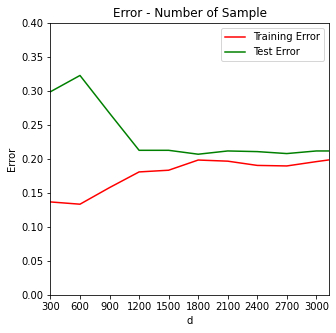

In [73]:
# Plot the training and testing error as a function of sample number
fig, ax = plt.subplots(figsize=(5,5))
# First plot
ax.set_title("Error - Number of Sample")
ax.plot(partition, train_err,'r',label='Training Error')
ax.plot(partition, test_err,'g',label='Test Error')
ax.set_xlabel('d') 
ax.set_ylabel('Error')
ax.set_ylim([0, 0.4])
ax.set_xlim([300, 3133])
ax.xaxis.set_ticks(np.arange(300,3133,300))
ax.legend();